# Лабораторная работа № 4

## Данные

In [179]:
%pylab inline
import pandas as pd

data = pd.read_csv('data.csv', sep=';',index_col=['month'], parse_dates=['month'], dayfirst=True)
data = data.rename(columns={'WAG_C_M': 'salary'})
data.info()
data.head()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   salary  284 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


C:\Users\Whim\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['real', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


salary
month             
1993-01-01    15.3
1993-02-01    19.1
1993-03-01    23.6
1993-04-01    30.6
1993-05-01    37.5

## Часть 1

### Визуализация данных

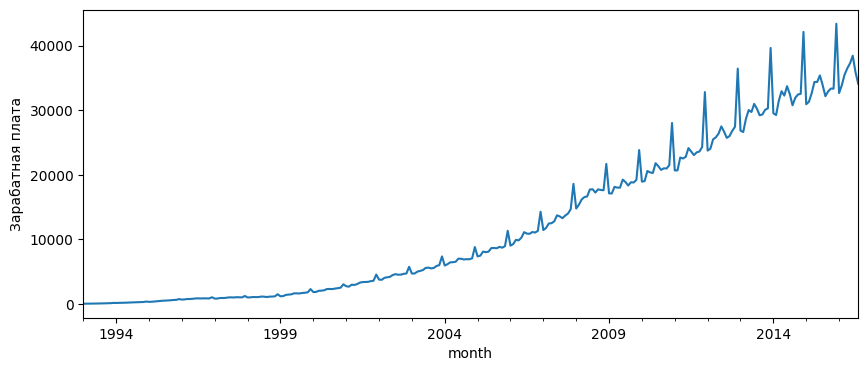

In [157]:
import matplotlib.pyplot as plt

plt.figure(figsize(10,4))
data.salary.plot()
plt.ylabel('Зарабатная плата')
pylab.show()

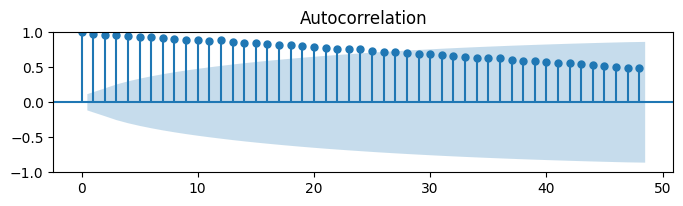

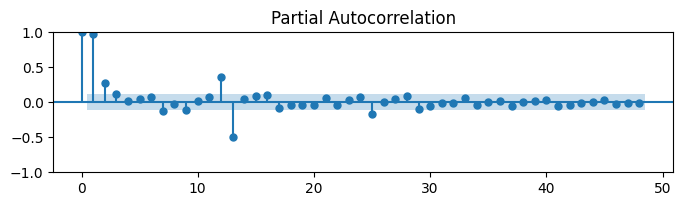

In [158]:
plt.figure(figsize(8,4))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary, lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary, lags=48, ax=ax)
pylab.show()

### Проверка на стационарность

Временной ряд $y_1,\ ..., y_T$ называется **стационарным**, если $\forall s$ (ширина окна) распределение $y_t,\ ..., y_{t+s}$ не зависит от $t$, т.е. его свойства не зависятот времени.

Критерий Дики-Фуллера: p=0.9918495954854735


<Figure size 900x600 with 0 Axes>

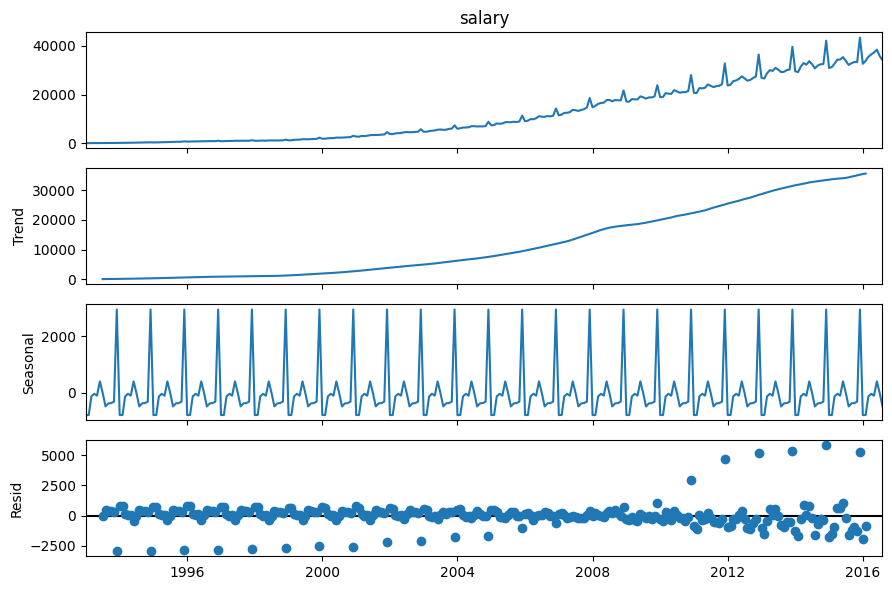

In [159]:
from scipy import stats
import statsmodels.api as sm

plt.figure(figsize(9,6))

sm.tsa.seasonal_decompose(data.salary).plot('-')
# pylab.show()

print(f"Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(data.salary)[1] }")

### Стабилизация дисперсии

In [160]:


data['salary_box'], lmbda = stats.boxcox(data.salary)

plt.figure(figsize(10,4))
data.salary_box.plot()
plt.ylabel(u'Transformed data salary')

print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda}")
print(f"Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(data.salary_box)[1]}")

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584
Критерий Дики-Фуллера: p=0.6968987634832664


### Делаем ряд стационарным

In [161]:
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)

plt.figure(figsize(9,6))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()

print(f"Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1]}")

Критерий Дики-Фуллера: p=0.014697133494791806


<Figure size 900x600 with 0 Axes>

Критерий Дики-Фуллера: p=5.2036037158227097e-08


<Figure size 900x600 with 0 Axes>

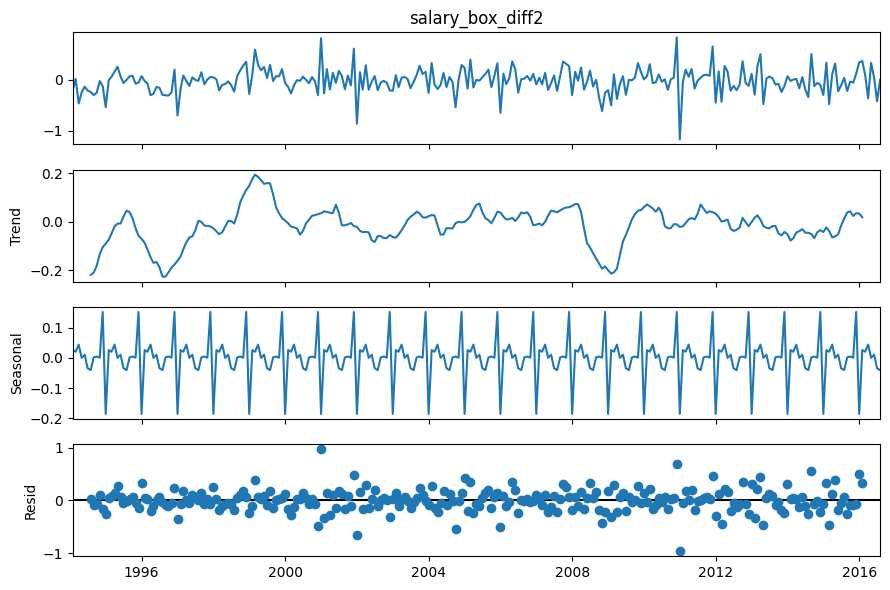

In [162]:
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)

plt.figure(figsize(9,6))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()   

print(f"Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1]}")

### Подбор модели

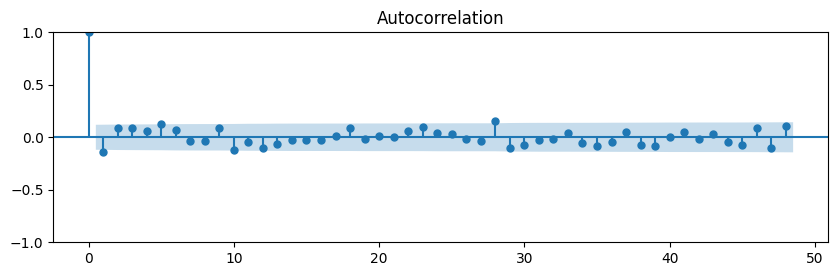

In [163]:
plt.figure(figsize(10,6))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [164]:

from itertools import product

# количество авторегрессионных компонент
p = range(2, 4) # [2; 3]
# количество раз, которое нужно применить операцию дифференцирования, чтобы преобразовать нестационарный ряд в стационарный
d = range(1, 3) # [1; 2]
# количество скользящих средних
q = range(2, 4) # [2; 3]

# тоже самое но с сезонностью
s = 12 
P = range(0, 2) # [0; 1]
D = range(1, 2) # [1; 1]
Q = range(0, 1) # [0; 0]


parameters = product(p, d, q, P, D, Q)
parameters_list = list(parameters)
len(parameters_list)

16

In [165]:
%%time

import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: total: 16.5 s
Wall time: 17.1 s


In [166]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(20))

            parameters        aic
0   (2, 1, 2, 0, 1, 0) -21.488595
1   (2, 1, 2, 1, 1, 0) -21.473461
2   (2, 1, 3, 0, 1, 0) -21.087184
9   (3, 1, 2, 1, 1, 0) -20.451721
3   (2, 1, 3, 1, 1, 0) -20.398608
8   (3, 1, 2, 0, 1, 0) -20.263386
10  (3, 1, 3, 0, 1, 0) -18.690796
11  (3, 1, 3, 1, 1, 0) -18.637786
7   (2, 2, 3, 1, 1, 0) -14.474577
13  (3, 2, 2, 1, 1, 0)   2.000189
12  (3, 2, 2, 0, 1, 0)   5.523169
5   (2, 2, 2, 1, 1, 0)   6.466410
6   (2, 2, 3, 0, 1, 0)   7.186097
15  (3, 2, 3, 1, 1, 0)   7.250443
14  (3, 2, 3, 0, 1, 0)  11.303667
4   (2, 2, 2, 0, 1, 0)  11.646688


In [167]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Sat, 20 May 2023   AIC                            -21.489
Time:                                     17:47:51   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.950      0.000       1.400       1.571
ar.L2         -0.6838      

In [168]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot(style="bs", marker='.')
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.269819
Критерий Дики-Фуллера: p=0.000000

e:\software\python\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bs" (-> marker='s'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


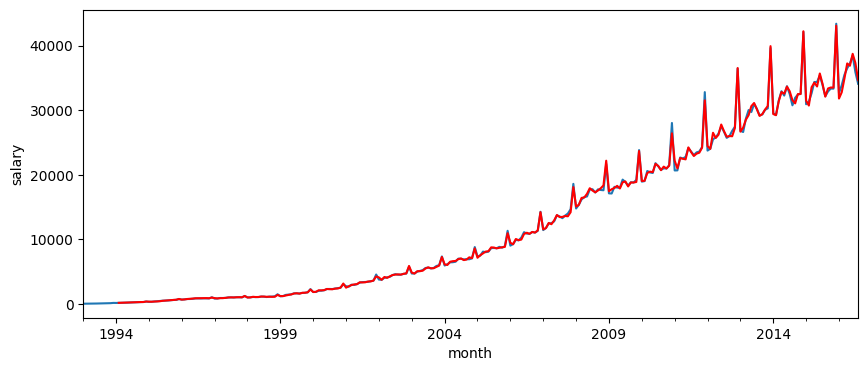

In [169]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

data['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize(10,4))

data.salary.plot()

data.model[13:].plot(color='r')

plt.ylabel('salary')

pylab.show()

### Прогноз

In [170]:
import datetime

real = pd.read_csv('test_data.csv', sep=';',index_col=['month'], parse_dates=['month'], dayfirst=True)

data2 = data[['salary']]

date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,78)]
future = pd.DataFrame(index=date_list, columns= data2.columns)

data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=285+78), lmbda)

plt.figure(figsize(15,7))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('salary')
real.value.plot(color='g')
pylab.show()

e:\software\python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\software\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\software\python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


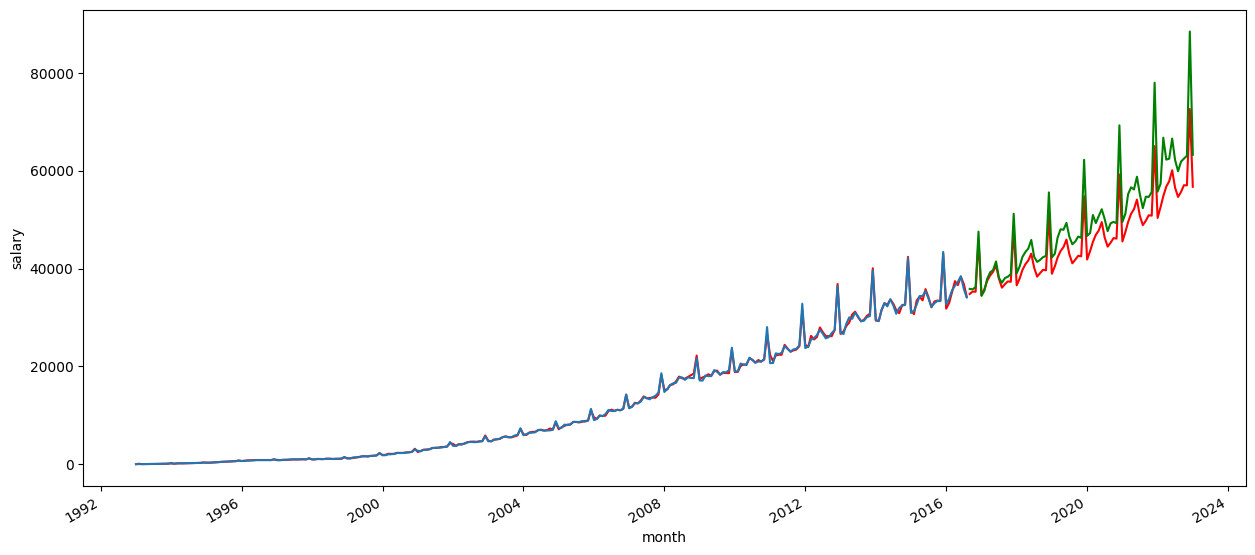

In [175]:
import datetime

real = pd.read_csv('test_data.csv', sep=';',index_col=['month'], parse_dates=['month'], dayfirst=True)

data2 = data[['salary']]

date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,78)]
future = pd.DataFrame(index=date_list, columns= data2.columns)

# SARIMAX(2, 1, 2)x(0, 1, [], 12)
second_model = sm.tsa.statespace.SARIMAX(data.salary_box, order=(3, 3, 3), 
                                        seasonal_order=(0, 1, 0, 12)).fit(disp=-1)

data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(second_model .predict(start=284, end=285+78), lmbda)

plt.figure(figsize(15,7))
data2.forecast.plot(color='r')
invboxcox(second_model.fittedvalues, lmbda).plot(color='r')
plt.ylabel('salary')
data2.salary.plot()
real.value.plot(color='g')
pylab.show()

## Часть 2

In [247]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt

def plot_series(time, series, size=(5, 3), format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=size)
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

### Подготовка данных

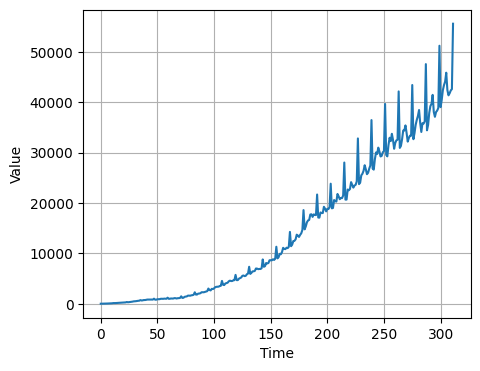

In [248]:
train_data = pd.read_csv('data.csv', delimiter=';',parse_dates=['month'], dayfirst=True)

train_size = train_data.shape[0]
time_train = np.arange(0, train_size, step=1)
x_train = train_data.WAG_C_M.to_numpy()


test_data = pd.read_csv('test_data24.csv', delimiter=';',parse_dates=['month'], dayfirst=True)

test_size = test_data.shape[0]
time_test = np.arange(train_size, train_size + test_size)
x_test = test_data.value.to_numpy()

time = np.concatenate([time_train, time_test])
values = np.concatenate([x_train, x_test])

plot_series(time, values, (5, 4))

In [249]:
window_size = 3
batch_size = 32
shuffle_buffer_size = 1000

train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

###  Однойслойный перцептрон

#### Build

In [250]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.summary()

# Set the training parameters
model.compile(loss="mse")

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


#### Train

In [251]:
model.fit(train_dataset,epochs=128, verbose=None)

In [252]:
model.get_weights()

[array([[0.02133428],
        [0.7735781 ],
        [0.21894617]], dtype=float32),
 array([0.4848062], dtype=float32)]

#### Prediction

In [253]:

forecast = []

for time_point in range(len(values) - window_size):
  forecast.append(model.predict(values[time_point:time_point + window_size][np.newaxis], verbose=None))

# Slice the points that are aligned with the validation set
# forecast = forecast[train_size - window_size:]

оранжевый - изначальный  
синий - то что нашли

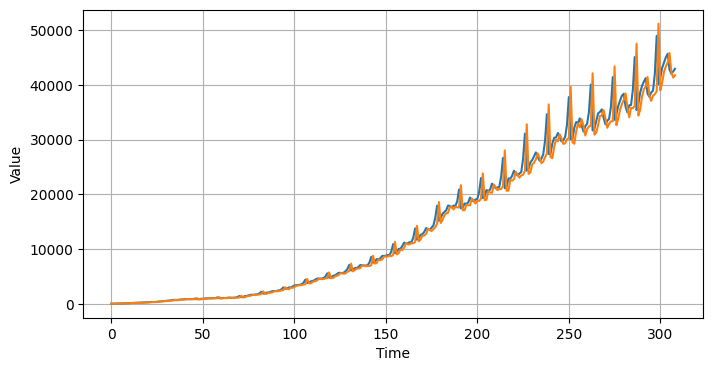

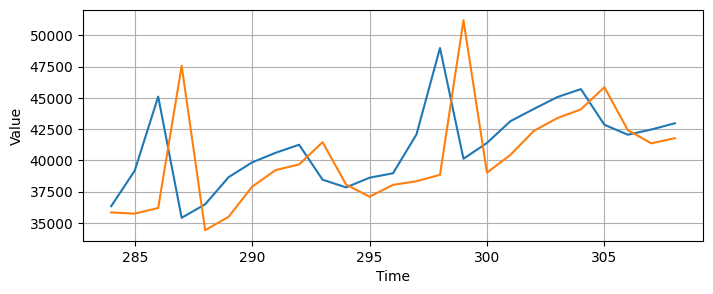

In [254]:
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
win = -(window_size)
plot_series(time[:win], (results, values[:win]), (8, 4))
plot_series(time[train_size:win], (results[train_size:], values[train_size:win]), (8, 3))

In [255]:
# Compute the metrics
import math 
print(math.sqrt(tf.keras.metrics.mean_squared_error(x_test, results[train_size - window_size:]).numpy()))
print(tf.keras.metrics.mean_absolute_error(x_test, results[train_size - window_size:]).numpy())

5045.440912348494
3359.423


### RNN

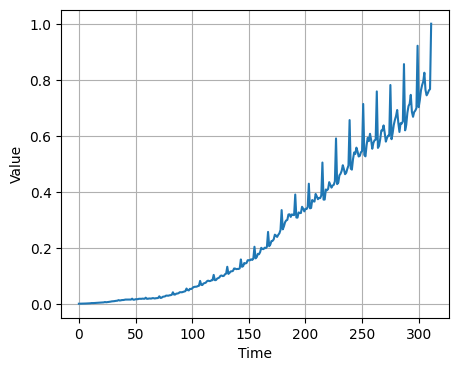

In [263]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
n_values = scaler.fit_transform(values.reshape(-1, 1))
n_x_train = n_values[:train_size].reshape(-1, 1).squeeze()
n_x_test = n_values[train_size:].reshape(-1, 1).squeeze()

window_size = 3
batch_size = 32
shuffle_buffer_size = 1000

n_dataset = windowed_dataset(n_x_train, window_size, batch_size, shuffle_buffer_size)
plot_series(time, n_values, (5, 4))

#### Build

In [264]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
     tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(1)
])


#### Train

In [265]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
model.fit(n_dataset, epochs=100)

Epoch 1/100
9/9 [==============================] - 1s 8ms/step - loss: 0.0357
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0032
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 8.4464e-04
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 5.9214e-04
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 5.8801e-04
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 6.0658e-04
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 5.6976e-04
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 5.8183e-04
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 5.7103e-04
Epoch 13/100
9/9 [===============

#### Predict

[array([[-0.00137585]], dtype=float32), array([[-0.00129507]], dtype=float32), array([[-0.00118709]], dtype=float32), array([[-0.00105323]], dtype=float32), array([[-0.00089683]], dtype=float32), array([[-0.00072234]], dtype=float32), array([[-0.00054643]], dtype=float32), array([[-0.00031619]], dtype=float32), array([[-6.138813e-05]], dtype=float32), array([[0.00016707]], dtype=float32), array([[0.0005685]], dtype=float32), array([[0.00089252]], dtype=float32), array([[0.00093726]], dtype=float32), array([[0.0012099]], dtype=float32), array([[0.00146669]], dtype=float32), array([[0.00165611]], dtype=float32), array([[0.00198286]], dtype=float32), array([[0.00233233]], dtype=float32), array([[0.00257945]], dtype=float32), array([[0.00287249]], dtype=float32), array([[0.00317968]], dtype=float32), array([[0.00350992]], dtype=float32), array([[0.00421]], dtype=float32), array([[0.00447907]], dtype=float32), array([[0.00419651]], dtype=float32), array([[0.00473283]], dtype=float32), array

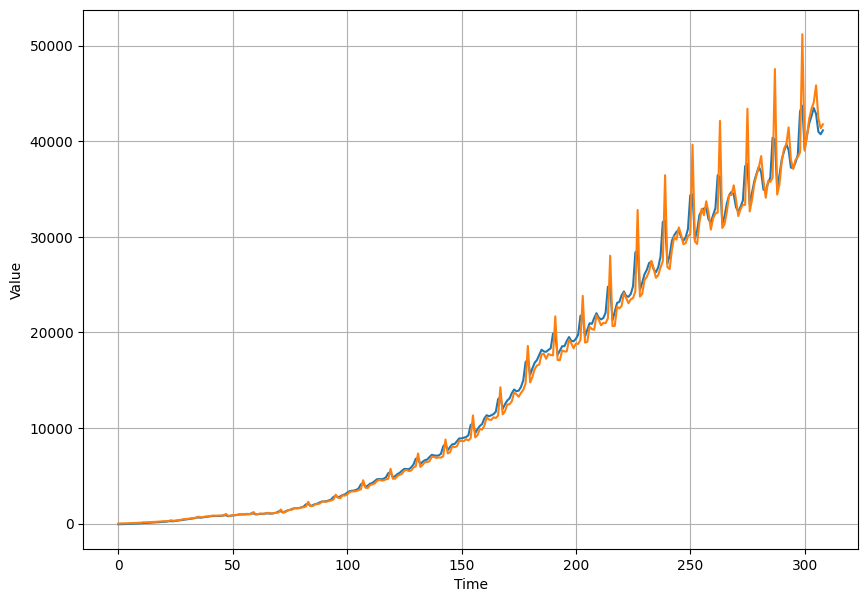

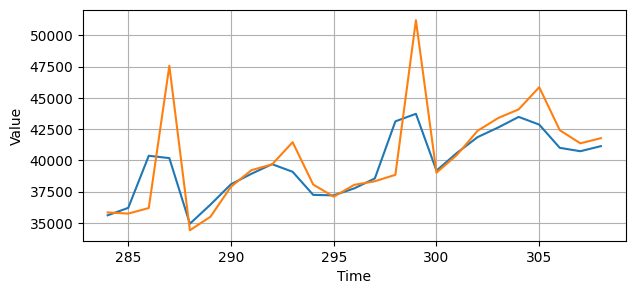

In [266]:

forecast = []

for time_point in range(len(values) - window_size):
  forecast.append(model.predict(n_values[time_point:time_point + window_size][np.newaxis], verbose=None))

print(forecast)
results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

# Overlay the results with the validation set
win = -(window_size)
plot_series(time[:win], (results, values[:win]), (10, 7))
plot_series(time[train_size:win], (results[train_size:], values[train_size:win]), (7, 3))

In [267]:
print(math.sqrt(tf.keras.metrics.mean_squared_error(x_test, results[train_size - window_size:]).numpy()))
print(tf.keras.metrics.mean_absolute_error(x_test, results[train_size - window_size:]).numpy())

4945.519588476018
3309.2864


### LSTM

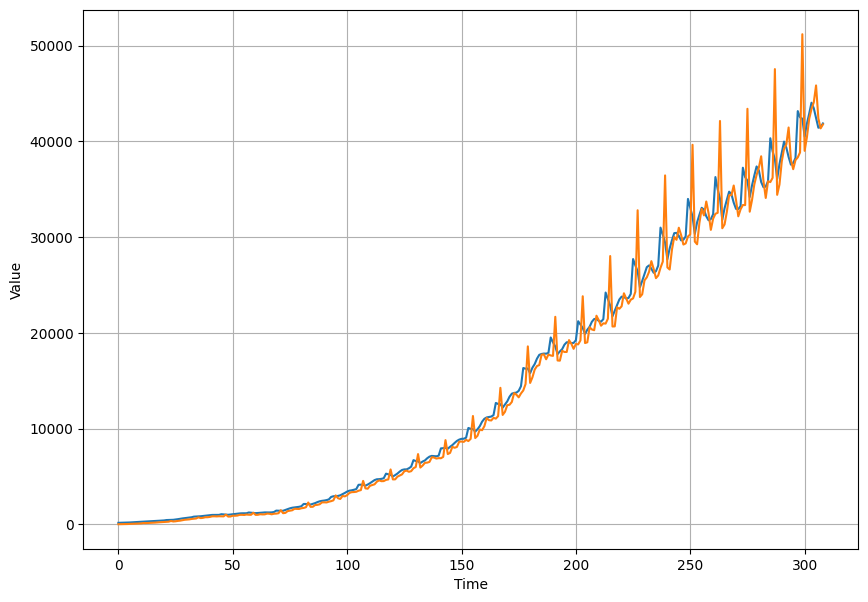

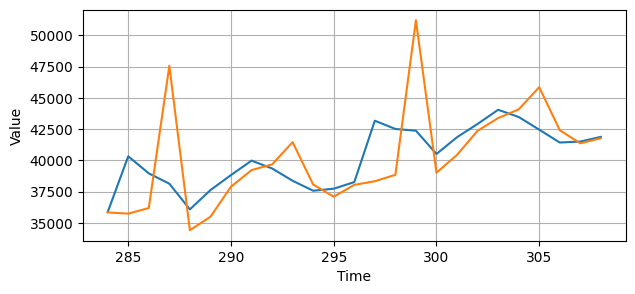

4719.69384600315
3010.0867


In [268]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
     tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

model.fit(n_dataset, epochs=100, verbose=None)

forecast = []

for time_point in range(len(values) - window_size):
  forecast.append(model.predict(n_values[time_point:time_point + window_size][np.newaxis], verbose=None))

results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

win = -(window_size)
plot_series(time[:win], (results, values[:win]), (10, 7))
plot_series(time[train_size:win], (results[train_size:], values[train_size:win]), (7, 3))

print(math.sqrt(tf.keras.metrics.mean_squared_error(x_test, results[train_size - window_size:]).numpy()))
print(tf.keras.metrics.mean_absolute_error(x_test, results[train_size - window_size:]).numpy())

### Convolutions c LSTM

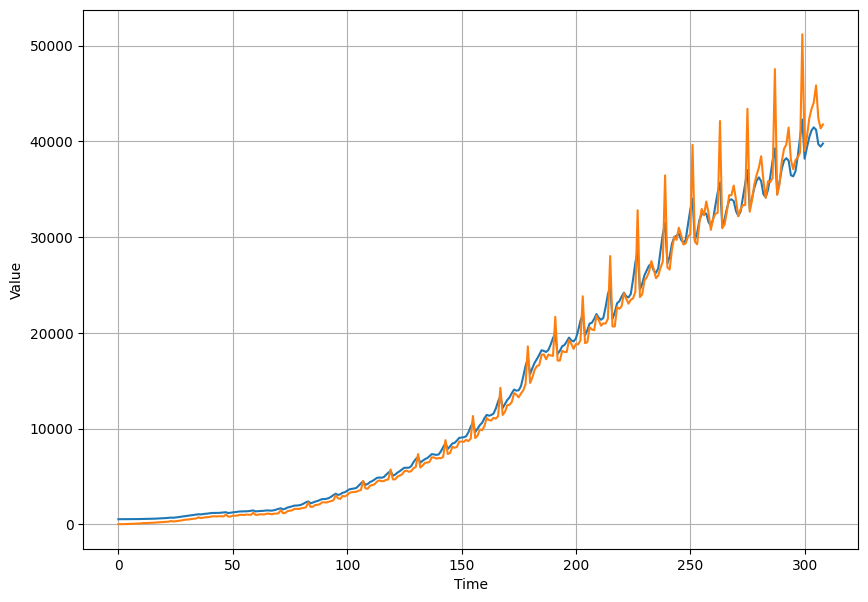

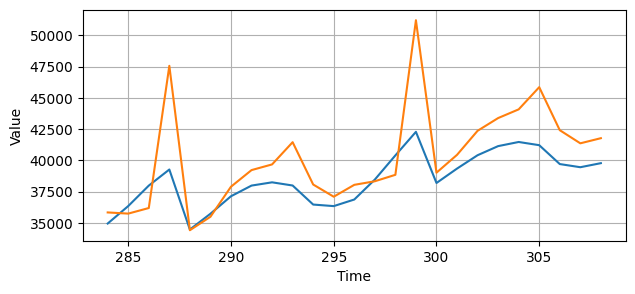

5332.539920150622
3363.3394


In [277]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM( 20 , return_sequences=True),
  tf.keras.layers.LSTM( 20 ),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

model.fit(n_dataset, epochs=100, verbose=None)

forecast = []

for time_point in range(len(values) - window_size):
  forecast.append(model.predict(n_values[time_point:time_point + window_size][np.newaxis], verbose=None))

results = scaler.inverse_transform(np.array(forecast).squeeze().reshape(-1, 1)).squeeze()

win = -(window_size)
plot_series(time[:win], (results, values[:win]), (10, 7))
plot_series(time[train_size:win], (results[train_size:], values[train_size:win]), (7, 3))

print(math.sqrt(tf.keras.metrics.mean_squared_error(x_test, results[train_size - window_size:]).numpy()))
print(tf.keras.metrics.mean_absolute_error(x_test, results[train_size - window_size:]).numpy())